# Header for Software License

                                                         
Copyright (C) 2014, Institute for Defense Analyses             
4850 Mark Center Drive, Alexandria, VA; 703-845-2500           
This material may be reproduced by or for the US Government    
pursuant to the copyright license under the clauses at DFARS   
252.227-7013 and 252.227-7014.                                 
                                                               
LARC : Linear Algebra via Recursive Compression                
Authors:                                                       
   * Steve Cuccaro (IDA-CCS)                                    
   * John Daly (LPS)                                            
   * John Gilbert (UCSB, IDA adjunct)                           
   * Jenny Zito (IDA-CCS)                                       
                                                               
Additional contributors are listed in "LARCcontributors".      
                                                               
Questions: larc@super.org                                      
                                                                
All rights reserved.                                       
                                                           
Redistribution and use in source and binary forms, with or  
without modification, are permitted provided that the
following conditions are met:                          
  * Redistribution of source code must retain the above copyright notice, this list of conditions and the following disclaimer. 
  *  Redistribution in binary form must reproduce the above  copyright notice, this list of conditions and the  following disclaimer in the documentation and/or other  materials provided with the distribution.  
  * Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission. 

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, 
INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED.  IN NO EVENT SHALL THE COPYRIGHT HOLDER NOR 
CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; 
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, 
STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR  OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

## Warning!!!

**Due to how Jupyter I/O is implemented, any printout originating from the LARC C code will be directed to the Jupyter console window (i.e., the terminal window that you typed "jupyter notebook" in), instead of in the notebook cell itself.**

In [1]:
import os
import sys 
sys.path.append("../../src")
import pylarc
from ctypes import *
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# print "This code tests some basic matrix building and reading routines\n"
# initialize larc
mat_store_exp = 15
op_store_exp = 5
max_level = 10
rnd_sig_bits = -1   # default value
trunc_to_zero_bits = -1  # default value
pylarc.create_report_thread(1800)
verbose = 1
pylarc.initialize_larc(mat_store_exp,op_store_exp,max_level,rnd_sig_bits,trunc_to_zero_bits,verbose)

# Define string for using in formating filenames
if pylarc.cvar.scalarTypeDef == 'i':
    scalarType = "Integer"
elif pylarc.cvar.scalarTypeDef == 'c':
    scalarType = "Complex"
elif pylarc.cvar.scalarTypeDef == 'r':
    scalarType = "Real"
elif pylarc.cvar.scalarTypeDef == 'z':
    scalarType = "MPInteger"
elif pylarc.cvar.scalarTypeDef == 'q':
    scalarType = "MPRational"
elif pylarc.cvar.scalarTypeDef == 'v':
    scalarType = "MPRatComplex"
elif pylarc.cvar.scalarTypeDef == 'm':
    scalarType = "MPReal"
elif pylarc.cvar.scalarTypeDef == 'j':
    scalarType = "MPComplex"
else:
    raise Exception('scalarTypeDef %s was not handled.'%(pylarc.cvar.scalarTypeDef,))

# Calculate number of matrices created, then print part of matrix store
num_matrices_made = pylarc.num_matrices_created()
print("\n%d matrices have been created" %num_matrices_made)
end = num_matrices_made - 1
filename = "../dat/out/preload.%s.store" %scalarType
pylarc.fprint_store_info_for_matrixID_range(0,end,filename,"After preload with parameters: 26, 24, 10.")
print("\nThe initial matrix store can be seen in %s\n" %filename)

# type control return to execute this code block



166 matrices have been created

The initial matrix store can be seen in ../dat/out/preload.Complex.store



In [2]:
    
    
    # SAMPLE ACTIVITES WITH MATRIX INPUT AND OUTPUT, & LEARNING PYTHON
    verbose = 1
    
    # reading prewritten nonsquare matrices, and naive printout
    filename = "../dat/in/sample.1.2.%s.json" %scalarType
    sampmID = pylarc.read_larcMatrixFile(filename)
    if verbose:
        print("Read in json file %s\n" %filename)
        print("Which is the matrix with matrixID %d\n" %sampmID)
        print("Printing this matrix in standard format gives:\n")
        pylarc.print_naive(sampmID)
        print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
        print("\n")
    
 
    # create a matrix in python for various scalar types: int, complex, real
    if pylarc.cvar.scalarTypeDef in ('i', 'z'):
        a = np.matrix([[1, 3, 5, 6],
                       [8, 6, 3, 1],
                       [-9, 11, 13, 15],
                       [16, 13, 12, 10]])
    elif pylarc.cvar.scalarTypeDef in ('c', 'v', 'j'):
        a = np.matrix([[1+2j, 3+4j, 5+6j, 7+8j],
                       [8+7j, 6+5j, 3+4j, 1+2j],
                       [9+10j, 11+12j, 13+14j, 15+16j],
                       [16+15j, 14+13j, 12+11j, 10+9j]])
    elif pylarc.cvar.scalarTypeDef in ('r', 'q', 'm'):
        a = np.matrix([[1, 3, .5, 6],
                       [8, 6, 3, .1],
                       [-9, 11, 13, 1.5],
                       [16, 13, 12, 10]])
    else:
        raise Exception('Do not know how to build matrix for type %s.'%(pylarc.cvar.scalarTypeDef,))
    if verbose:
        a

        
    # convert python matrix into an array by reading off each row in turn (row major format)
    alist = a.reshape(-1).tolist()[0]
    if verbose:
        print('alist:', alist)
        
        
    # Use C routing row_major_list_to_store to
    # interpret the array as a row major list of a matrix
    # enter it into the matrix store and then return 
    # the matrixID of the stored matrix.
    if verbose:
        print("Using row_major_list_to_store on data entered from python\n")
    # parameters for entering the python array into the store
    level = 2
    dim_whole = 2**level
    # creating or finding the matrix associated with the array
    serial = pylarc.row_major_list_to_store(pylarc.map_to_str(alist, scalarType), level, level, dim_whole)
    if verbose:
        pylarc.print_naive(serial)
        print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
        print("\n")
   

    # Make a parent matrix from four copies of the a matrix 
    # as specified by its matrixID
    if verbose:
        print("Creating matrix from matrix_get_matrixID_from_panel on panel input and writing json file\n")
    panel = [serial]*4   # alternatively panel=[serial,serial,serial,serial]
    serial_parent = pylarc.get_pID_from_four_sub_pIDs(serial,serial,serial,serial,3,3)
    if verbose:
        pylarc.print_naive(serial_parent)
        print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
        
        
    # Writing a matrix to a file in our compressed form (json file)
    filename = "../dat/out/testfile.%s.json" %scalarType
    pylarc.fprint_larcMatrixFile(serial_parent,filename)
    if verbose:
        print("Wrote a matrix constructed from four panel submatrices to the file %s\n" %filename)
 

    #  Read in a compressed matrix (for the Toffoli gate)    
    filename = "../dat/in/toffoli.%s.json" %scalarType
    toffmID = pylarc.read_larcMatrixFile(filename)
    if verbose:
        print("Reading matrix file in compressed form (using json format)\n")
        print("   for the Toffoli gate from the file %s\n" %filename)
        pylarc.print_naive(toffmID)
        print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
        print("\n")

    # Reading and writing matrices in various formats
    if verbose:
        print("Matrices can be read or stored in many formats\n")
        print("  if small they can be written or read as row major matrices (rmm)\n")
        print("  if small they can be written in naive format\n")
        print("  if large they can be written or read in compressed format (json)\n")
        print("Testing reading row major matrix format and writing files in json and naive format.\n")
    filename_rmm = "../dat/in/sample.1.1.%s.rmm" %scalarType
    filename_naive = "../dat/out/sample.1.1.%s.naive" %scalarType
    filename_json = "../dat/out/sample.1.1.%s.json" %scalarType   
    samplemID = pylarc.read_row_major_matrix_from_file(filename_rmm)
    pylarc.fprint_naive(samplemID,filename_naive)
    pylarc.fprint_larcMatrixFile(samplemID,filename_json)
    if verbose:
        print("Printing out the rrm sample matrix in naive format to screen\n")
        pylarc.print_naive(samplemID)
        print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
        print("Testing reading row major nonsquare matrices and writing files in json and naive format.\n")
    filename_rmm = "../dat/in/sample.1.2.%s.rmm" %scalarType
    filename_naive = "../dat/out/sample.1.2.%s.naive" %scalarType
    filename_json = "../dat/out/sample.1.2.%s.json" %scalarType
    samplemID = pylarc.read_row_major_matrix_from_file(filename_rmm)
    pylarc.fprint_naive(samplemID,filename_naive)
    pylarc.fprint_larcMatrixFile(samplemID,filename_json)
    if verbose:
        print("Printing out the nonsquare rrm sample matrix in naive format to screen\n")
        pylarc.print_naive(samplemID)
        print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
        print("Test printing nonzeroes to file.\n")
    filename_rmm = "../dat/in/sample.1.3.%s.rmm" %scalarType
    filename_nonzeros = "../dat/out/sample.1.3.%s.nonzeros" %scalarType
    filename_json = "../dat/out/sample.1.3.%s.json" %scalarType
    samplemID = pylarc.read_row_major_matrix_from_file(filename_rmm)
    pylarc.fprint_matrix_nonzeros(samplemID,filename_nonzeros)
    pylarc.fprint_larcMatrixFile(samplemID,filename_json)
    if verbose:
        print("Printing the matrix we are testing for printing out nonzero values\n")
        pylarc.print_naive(samplemID)
        print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

        

Read in json file ../dat/in/sample.1.2.Complex.json

Which is the matrix with matrixID 172

Printing this matrix in standard format gives:

   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!


alist: [(1+2j), (3+4j), (5+6j), (7+8j), (8+7j), (6+5j), (3+4j), (1+2j), (9+10j), (11+12j), (13+14j), (15+16j), (16+15j), (14+13j), (12+11j), (10+9j)]
Using row_major_list_to_store on data entered from python

   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!


Creating matrix from matrix_get_matrixID_from_panel on panel input and writing json file

   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!
Wrote a matrix constructed from four panel submatrices to the file ../dat/out/testfile.Complex.json

Reading matrix file in compressed form (using json format)

   for the Toffoli gate from the file ../dat/in/toffoli.Complex.json

   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!


Matrices can be read or stored in many formats

  if small they can be written or read as row major matrices (rmm)

  if small they can be written in naive 

In [3]:
    verbose = 1
    
    # make CNOT
    if verbose:
        print("\nHere is the CNOT matrix\n")
    CNOT_alist = [1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0]
    CNOTmID = pylarc.row_major_list_to_store(list(map(str,CNOT_alist)),level,level,dim_whole)
    pylarc.print_naive(CNOTmID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    # Calculate number of matrices created, then print part of matrix store
    num_matrices_made = pylarc.num_matrices_created()
    print("\n%d matrices have been created" %num_matrices_made)
    start = end + 1
    end = num_matrices_made - 1
    filename = "../dat/out/cnot.%s.store" %scalarType
    pylarc.fprint_store_info_for_matrixID_range(start,end,filename,"Loaded CNOT")

    # build Zero matrices
    if verbose:
        print("\nHere is the level 2 zero matrix\n")
    Z2_alist = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    Z2mID = pylarc.row_major_list_to_store(list(map(str,Z2_alist)),level,level,dim_whole)
    pylarc.print_naive(Z2mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    # build Identity matrices
    if verbose:
        print("\nHere is the level 2 identity matrix\n")
    I2_alist = [1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1]
    I2mID = pylarc.row_major_list_to_store(list(map(str,I2_alist)),level,level,dim_whole)
    pylarc.print_naive(I2mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    # build a TOFFOLI
    if verbose:
        print("\nHere is the 3 bit TOFFOLI matrix with target 3rd.\n")
    TOFFOLImID= pylarc.get_pID_from_four_sub_pIDs(I2mID,Z2mID,Z2mID,CNOTmID,3,3)
    pylarc.print_naive(TOFFOLImID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
    filename = "../dat/out/toffoli.%s.naive" %scalarType
    pylarc.fprint_naive(TOFFOLImID,filename)


    #  PLAYING WITH PREWRITTEN NONSQUARE MATRIX
    filename = "../dat/in/sample.1.2.%s.json" %scalarType
    if verbose:
        print("About to test read %s\n" %filename)
    sampmID = pylarc.read_larcMatrixFile(filename)
    if verbose:
        print("We read in the json file\n")
    pylarc.print_naive(sampmID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
    
    if verbose:
        print("does scalarM1_val print?")
    scalarM1_val = -1
    scalarM1mID = pylarc.get_valID_from_valString(str(scalarM1_val))
    pylarc.print_naive(scalarM1mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
    
    if verbose:
        print("testing scalar_mult:")
    samp2mID = pylarc.scalar_mult(scalarM1mID,sampmID)
    pylarc.print_naive(samp2mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
    
    if verbose:
        print("testing addition:")
    samp3mID = pylarc.matrix_add(sampmID,samp2mID)
    pylarc.print_naive(samp3mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
    
    # save input matrixIDs for testing op store hash chains later
    in1_test_summID = sampmID
    in2_test_summID = samp2mID
    
    if verbose:
        print("testing adjoint:")
    samp3mID = pylarc.adjoint(sampmID)
    pylarc.print_naive(samp3mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
    adjmID = samp3mID
    
    if verbose:
        print("testing non-square matrix mult:")
    samp4mID = pylarc.matrix_mult(samp3mID,sampmID)
    pylarc.print_naive(samp4mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
    if verbose:
        print("")
    samp4mID = pylarc.matrix_mult(sampmID,samp3mID)
    pylarc.print_naive(samp4mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
    if verbose:
        print("testing kron product:")
    samp4mID = pylarc.kronecker_product(sampmID,sampmID)
    pylarc.print_naive(samp4mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
    

    if verbose:
        print("testing join:")
    samp4mID = pylarc.join(sampmID,sampmID)
    pylarc.print_naive(samp4mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")
    if verbose:
        print("testing stack:")
    samp4mID = pylarc.stack(sampmID,sampmID)
    pylarc.print_naive(samp4mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")



Here is the CNOT matrix

   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

204 matrices have been created

Here is the level 2 zero matrix

   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

Here is the level 2 identity matrix

   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

Here is the 3 bit TOFFOLI matrix with target 3rd.

   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!
About to test read ../dat/in/sample.1.2.Complex.json

We read in the json file

   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!
does scalarM1_val print?
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!
testing scalar_mult:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!
testing addition:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!
testing adjoint:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!
testing non-square matrix mult:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!
testing kron product:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!
testing join:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!
testing stack:
   SEE JUPYTER CONSOLE FOR 

In [4]:
    ##  TESTING DELETION
    print("\nPreparing to delete a matrix from the store.\n")
    filename = "../dat/out/temp.%s.json" %scalarType
    pylarc.fprint_larcMatrixFile(TOFFOLImID, filename)  
    pylarc.read_larcMatrixFile(filename)

    # Calculate number of matrices created, then print part of matrix store
    num_matrices_made = pylarc.num_matrices_created()
    print("\n%d matrices have been created" %num_matrices_made)
    print("Previous range printed ended with matrixID %d\n" %end)
    if (end == num_matrices_made-1) :
        print("Nothing new since last matrix store print\n")
    else :
        start = end + 1
        end = num_matrices_made - 1
        filename = "../dat/out/toffoli.%s.store" %scalarType
        pylarc.fprint_store_info_for_matrixID_range(start,end,filename,"Loaded Toffoli")

    # get the hashID and print the hash chain corresponding to a matrix we are about to delete
    hashID = pylarc.hash_pID(toffmID)
    comment = "hash chain before removal"
    filename = "../dat/out/hashChain.beforeMatrixRemove"
    pylarc.fprint_matrix_hash_chain_info(hashID, filename, comment)
    
    # Test deletion of a matrix
    print("Testing removal of matrix from the matrix store\n")
    num_matrices_made =  pylarc.num_matrices_created()
    end = num_matrices_made - 1
    filename = "../dat/out/toffoliYES.%s.store" %scalarType
    pylarc.fprint_store_info_for_matrixID_range(0,end,filename,"Before Removed Toffoli")

    pylarc.remove_matrix_from_store(toffmID)

    filename = "../dat/out/toffoliNO.%s.store" %scalarType
    filename_json = "../dat/out/temp.%s.json" %scalarType
    print("\nDeleting the toffoli matrix with matrixID", toffmID,"from store, which had been read from %s\n"  %filename_json)
    pylarc.fprint_store_info_for_matrixID_range(0,end,filename,"Removed Toffoli")

    comment = "hash chain after removal"
    filename = "../dat/out/hashChain.afterMatrixRemove"
    pylarc.fprint_matrix_hash_chain_info(hashID, filename, comment)

    pylarc.list_op_names()
    print("   SEE JUPYTER CONSOLE FOR LARC OPERATION NAMES!")



Preparing to delete a matrix from the store.


302 matrices have been created
Previous range printed ended with matrixID 203

Testing removal of matrix from the matrix store


Deleting the toffoli matrix with matrixID 194 from store, which had been read from ../dat/out/temp.Complex.json

   SEE JUPYTER CONSOLE FOR LARC OPERATION NAMES!


In [5]:
    
    # Test op store hash chains after deletion

    # print ops store report before deletion of a matrix
    pylarc.op_store_report("jupyter_op_store_report.txt")
    
    # need op name to find the hash value so we can print op store hash chain
    op_name = "SUM"
    
    # get hash for an operation record and print the hash chain
    sum_hashID = pylarc.op_hashID_by_matrixIDs(in1_test_summID,in2_test_summID,op_name)
    if (sum_hashID != -1):
        pylarc.op_hash_chain_info_to_screen(sum_hashID,"op hash chain before deletion")
        print("   SEE JUPYTER CONSOLE FOR HASH CHAIN OUTPUT!")
    else:
        print("invalid matrixID requested for op hash chain")
    
    # delete the first input matrix
    pylarc.remove_matrix_from_store(in1_test_summID)
    print("deleting matrix with matrixID", in1_test_summID)
    
    # set a hold on a matrix by matrixID to see if it is immune to cleaning
    print("The matrixID of matrix to be held is", adjmID)
    pylarc.set_hold_matrix(adjmID)
    
    # clean the matrix store and print it again
    pylarc.clean_matrix_storage()
    filename = "../dat/out/toffoliNOcleaned.%s.store" %scalarType
    pylarc.fprint_store_info_for_matrixID_range(0,end,filename,"Removed Toffolli and cleaned matrix store")

    # clean the op store 
    # try one of three cleaning functions
    
    # clean a single op
    # pylarc.clean_single_op_from_string("SUM")
    
    # clean entire store
    # pylarc.clean_entire_op_store() 
    
    # clean entire store, one hash at a time
    for hash in range(1<<op_store_exp):
        pylarc.clean_op_hash_chain(hash) 
    
    # print same op hash chain again after deleting a matrix, holding a matrix and cleaning
    if (sum_hashID != -1):
        pylarc.op_hash_chain_info_to_screen(sum_hashID,"op hash chain after deletion and cleaning")
        print("   SEE JUPYTER CONSOLE FOR HASH CHAIN OUTPUT!")
    else:
        print("invalid matrixID requested for op hash chain")
    

   SEE JUPYTER CONSOLE FOR HASH CHAIN OUTPUT!
deleting matrix with matrixID 172
The matrixID of matrix to be held is 216
   SEE JUPYTER CONSOLE FOR HASH CHAIN OUTPUT!


In [6]:
max_level
diag_hist = []
for i in range(max_level):
    diag_hist.append(pylarc.get_counts_square_matrices_by_level(i))
diag_hist


[18, 6, 4, 4, 4, 4, 4, 4, 4, 4]

In [7]:
Earlier = [14, 6, 4, 4, 4, 4, 3, 2, 2, 1]

Earlier


[14, 6, 4, 4, 4, 4, 3, 2, 2, 1]

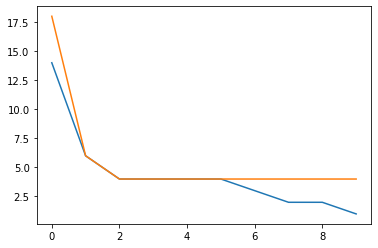

[14, 6, 4, 4, 4, 4, 3, 2, 2, 1]

In [8]:
plt.plot(Earlier)
plt.plot(diag_hist)
plt.show()
Earlier



mat_store_exp is 15
size_hash_table is 32768


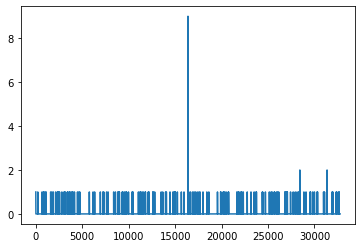

[32604, 160, 2, 0, 0, 0, 0, 0, 0, 1]

In [9]:
#### CREATE A HISTOGRAM OF HASH CHAIN LENGTHS  ####

mat_store_exp
size_hash_table = 2**mat_store_exp
matrix_hash_chain_count = []
# pylarc.matrix_hash_chain_length(3)
print("mat_store_exp is %d" %mat_store_exp)
print("size_hash_table is %d" %size_hash_table)
hash_hist = 10 * [0]

arrayA = [0 for i in range(size_hash_table)]
for i in range(size_hash_table-1):
    count = pylarc.matrix_hash_chain_length(i)
    hash_hist[count] += 1
    # if count > 0:
    #    print("The number of entries in the %d hash chain of the table is %d"  %(i,count))
    matrix_hash_chain_count.append(count)
    
size_hash_table
if (size_hash_table <= 64):
    # show the array of hash chain lengths
    matrix_hash_chain_count
plt.plot(matrix_hash_chain_count)
plt.show()

hash_hist

mat_store_exp is 15
size_hash_table is 32768
mat_chain_length[0] is 1
mat_chain_length[1] is 0
mat_chain_length[2] is 0
mat_chain_length[3] is 0
zero_counts is 32605


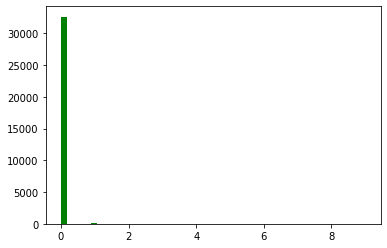

In [10]:
#### CREATE A HISTOGRAM OF HASH CHAIN LENGTHS  ####

# Calculate size of matrix store hash table
print("mat_store_exp is %d" %mat_store_exp)
size_mat_hash_table = 2**mat_store_exp
print("size_hash_table is %d" %size_mat_hash_table)

# Make an array of all the lengths of the hash chains in the store
mat_chain_length = [0 for i in range(size_mat_hash_table)]

zero_counts = 0
for i in range(size_mat_hash_table):
    mat_chain_length[i] = pylarc.matrix_hash_chain_length(i)
    if (mat_chain_length[i] == 0):
        zero_counts = zero_counts + 1
    if i < 4:
        print("mat_chain_length[%d] is %d" %(i,mat_chain_length[i]))

        
print("zero_counts is %d" %zero_counts)
# make histogram of the mat_chain_length
n, bins, patches = plt.hist(mat_chain_length, 50, density=0, facecolor='green', alpha=1)

plt.show()

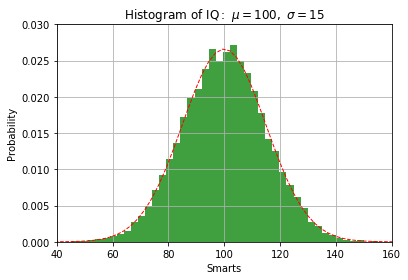

In [18]:
mu, sigma = 100, 15
x = mu + sigma*np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(x, 50, density=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = scipy.stats.norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.axis([40,160, 0, 0.03])
plt.grid(True)

plt.show()

49660454
40
36
34
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 8.000e+00 2.400e+01 3.800e+01 9.700e+01 1.460e+02 2.550e+02 3.830e+02
 5.250e+02 7.170e+02 1.024e+03 1.238e+03 1.546e+03 1.758e+03 2.097e+03
 2.295e+03 2.291e+03 2.403e+03 2.369e+03 2.174e+03 1.987e+03 1.798e+03
 1.582e+03 1.416e+03 1.056e+03 8.800e+02 7.840e+02 5.210e+02 4.300e+02
 2.790e+02 2.170e+02 1.320e+02 1.040e+02 6.200e+01 5.500e+01 3.100e+01
 1.500e+01 1.900e+01 5.000e+00 2.000e+00 0.000e+00 3.000e+00] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55] <a list of 55 Patch objects>


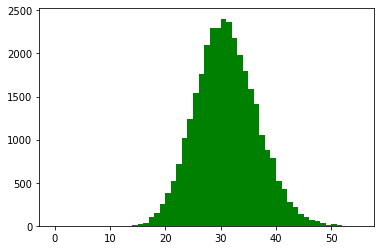

In [12]:
print(pylarc.recursive_hash_from_four_integers(5,22,0,4,30))

h_exp = 15
def random_hash(h_exp):
    h_size = 2**h_exp
    a = [0 for i in range(4)]
    for i in range(4):
        a[i] = np.random.randint(1,h_size)   
    # print(a)
    return pylarc.recursive_hash_from_four_integers(a[0],a[1],a[2],a[3],h_exp)
                                       
h_table = [0 for i in range(2**h_exp)]  


for j in range(1000000):
    h_table[random_hash(h_exp)] += 1

# c = random_hash(h_exp)
# print c
for k in range(3):
    print(h_table[k])

# make histogram of the hash table
n, bins, patches = plt.hist(h_table,range(np.max(h_table)+1), density=0, facecolor='green', alpha=1)
print(n, bins, patches)
plt.show()
    

In [13]:
dir(pylarc)

['ADJOINT',
 'ALL',
 'ARRAY',
 'ArgumentError',
 'Array',
 'BASIC',
 'BASIS_CHANGE',
 'BINARY_PROD',
 'BigEndianStructure',
 'CDLL',
 'CFUNCTYPE',
 'CHATTY',
 'COL_VECTOR',
 'COMMENT',
 'COMPUTER',
 'DATE',
 'DEBUG',
 'DEFAULT_MATRIX_STORE_EXPONENT',
 'DEFAULT_MAX_LEVEL',
 'DEFAULT_MODE',
 'DEFAULT_OP_STORE_EXPONENT',
 'DEFAULT_REGIONBITPARAM',
 'DIFF',
 'ENTRYSQUARE',
 'FUNC_A',
 'FUNC_B',
 'FUNC_C',
 'INPUTVEC',
 'INVALID_INFO',
 'INVALID_OP',
 'JOIN',
 'KRONECKER',
 'LARC_SIZE',
 'L_1',
 'L_2',
 'L_infty',
 'LarcSettings',
 'LibraryLoader',
 'LittleEndianStructure',
 'MATRIX',
 'MATRIX_OR',
 'MAX_ELEMENT',
 'NORM_VAL',
 'NUMROUNDS',
 'OTHERINFO',
 'OTHERMATRIX',
 'POINTER',
 'PRODUCT',
 'PYFUNCTYPE',
 'PyDLL',
 'QUOTIENT_SCALAR',
 'ROW_VECTOR',
 'RTLD_GLOBAL',
 'RTLD_LOCAL',
 'SCALAR',
 'SCALELOG',
 'SILENT',
 'STACK',
 'SUM',
 'SetPointerType',
 'Structure',
 'Union',
 'ZEROCOUNT',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',


In [14]:
    ################################
    # inverse permutation matrices #
    ################################
    print("\nPI_0 matrix is:")
    PI_0 = pylarc.create_invShufMat(0)
    pylarc.print_naive(PI_0)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    print("\nPI_1 matrix is:")
    PI_1 = pylarc.create_invShufMat(1)
    pylarc.print_naive(PI_1)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    print("\nPI_2 matrix is:")
    PI_2 = pylarc.create_invShufMat(2)
    pylarc.print_naive(PI_2)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    print("\nPI_3 matrix is:")
    PI_3 = pylarc.create_invShufMat(3)
    pylarc.print_naive(PI_3)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    print("\nPI_4 matrix is:")
    PI_4 = pylarc.create_invShufMat(4)
    pylarc.print_naive(PI_4)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")



PI_0 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

PI_1 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

PI_2 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

PI_3 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

PI_4 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!


In [15]:
if pylarc.cvar.scalarTypeDef not in ('c', 'v', 'j'):
    print("Scalar type %s ('%s') does not support this functionality." % (scalarType, pylarc.cvar.scalarTypeDef))
else:
    #########################
    # print roots of unity  #
    #########################
    print("Roots of Unity matrices are:\n")
    pylarc.print_pow2_roots_unity(1)
    pylarc.print_pow2_roots_unity(2)
    pylarc.print_pow2_roots_unity(3)


Roots of Unity matrices are:



In [16]:
if pylarc.cvar.scalarTypeDef not in ('c', 'v', 'j'):
    print("Scalar type %s ('%s') does not support this functionality." % (scalarType, pylarc.cvar.scalarTypeDef))
else:
    ###############################
    # create D matrices in python #
    ###############################
    print("\nD_0 matrix is:")
    D_0 = pylarc.create_FFT_DMat(0)
    pylarc.print_naive(D_0)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    print("\nD_1 matrix is:")
    D_1 = pylarc.create_FFT_DMat(1)
    pylarc.print_naive(D_1)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    print("\nD_2 matrix is:")
    D_2 = pylarc.create_FFT_DMat(2)
    pylarc.print_naive(D_2)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    print("\nD_3 matrix is:")
    D_3 = pylarc.create_FFT_DMat(3)
    pylarc.print_naive(D_3)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")


    ###############################
    # create C matrices in python #
    ###############################
    print("\nC_1 matrix is:")
    C_1 = pylarc.create_FFT_CMat(1)
    pylarc.print_naive(C_1)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    print("\nC_2 matrix is:")
    C_2 = pylarc.create_FFT_CMat(2)
    pylarc.print_naive(C_2)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    print("\nC_3 matrix is:")
    C_3 = pylarc.create_FFT_CMat(3)
    pylarc.print_naive(C_3)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")



D_0 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

D_1 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

D_2 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

D_3 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

C_1 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

C_2 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

C_3 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!


In [17]:
if pylarc.cvar.scalarTypeDef not in ('c', 'v', 'j'):
    print("Scalar type %s ('%s') does not support this functionality." % (scalarType, pylarc.cvar.scalarTypeDef))
else:
    #################################
    # create FFT matrices in python #
    #################################
    print("\nF_1 matrix is:")
    F_1 = pylarc.create_FFTMat(1)
    pylarc.print_naive(F_1)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    print("\nF_2 matrix is:")
    F_2 = pylarc.create_FFTMat(2)
    pylarc.print_naive(F_2)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    print("\nF_3 matrix is:")
    F_3 = pylarc.create_FFTMat(3)
    pylarc.print_naive(F_3)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")


    #################################
    # create FFT matrices in python #
    #################################
    print("\nCreate a vector\n")
    A_arr = list(map(str,[1,0,0,0,0,1,0,0]))
    rowLevel = 3
    colLevel = 0
    dimWhole = 1 << colLevel
    A_mID = pylarc.row_major_list_to_store(A_arr,rowLevel,colLevel,dimWhole)
    pylarc.print_naive(A_mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    print("Now multiply FFT matrix by the vector to get the result\n")
    B_mID = pylarc.matrix_mult(F_3,A_mID)
    pylarc.print_naive(B_mID)
    print("   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!")

    ## The following lines only work if the C code has been compiled with
    ## #define HASHSTATS

    #filename_a = "../dat/out/hashaccesses.mat"
    #filename_n = "../dat/out/hashnodes.mat"
    #filename_r = "../dat/out/hashreport.mat"
    #pylarc.matrix_hashstats(filename_a,filename_n,filename_r)


    #filename_a = "../dat/out/hashaccesses.op"
    #filename_n = "../dat/out/hashnodes.op"
    #filename_r = "../dat/out/hashreport.op"
    #pylarc.op_hashstats(filename_a,filename_n,filename_r)



F_1 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

F_2 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

F_3 matrix is:
   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!

Create a vector

   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!
Now multiply FFT matrix by the vector to get the result

   SEE JUPYTER CONSOLE FOR MATRIX OUTPUT!
